# ROM Autoencoder
This notebook implements fully-connected networks using a more modular approach into an autoencoder.

In [64]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from cs231n.classifiers.rom_autoencoder import *
from cs231n.rom_utils import load_burg_data, sample_burg_minibatch
from cs231n.rom_solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load BURG data
We will use the BURG dataset for finding the PDE solutions.

In [65]:
# Load BURG data from disk; this returns a dictionary
train_data = load_burg_data('snaps_0p05_0p02_5.dat','snaps_0p05_0p02_1.dat')
val_data = load_burg_data('snaps_0p05_0p02_2p5.dat')

# Print out all the keys and values from the data dictionary
def print_data(data):
    for k, v in data.iteritems():
      if type(v) == np.ndarray:
        print k, type(v), v.shape, v.dtype
        if k == 'features':
            for i in v:
                print i
        else:
            for i in v:
                print i.shape   
      else:
        print k, type(v), len(v)
    
print 'train'
print_data(train_data)
print 'val'
print_data(val_data)

train
features <type 'numpy.ndarray'> (2L, 3L) float64
[ 0.05  0.02  5.  ]
[ 0.05  0.02  1.  ]
solutions <type 'numpy.ndarray'> (2L, 501L, 1000L) float64
(501L, 1000L)
(501L, 1000L)
val
features <type 'numpy.ndarray'> (1L, 3L) float64
[ 0.05  0.02  2.5 ]
solutions <type 'numpy.ndarray'> (1L, 501L, 1000L) float64
(501L, 1000L)


## Look at the BURG data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `load_burg_data` function from the file `cs231n/mor_utils.py` to get data. Run the following to show the parameters and their Burgers' equation solutions.

(200L, 1000L)


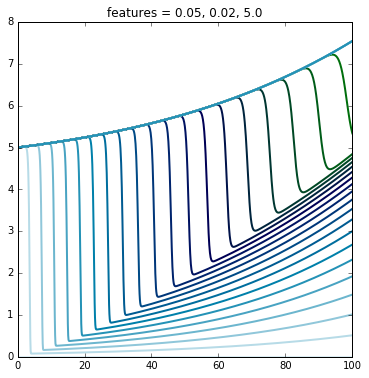

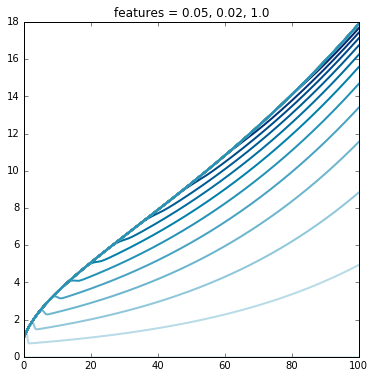

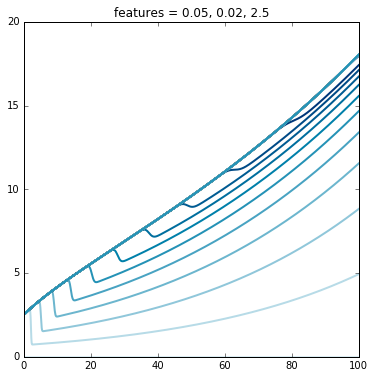

In [103]:
# Show the parameters and solutions
def plot_it(data, i=0, j=1, v_indices = np.array([0])):
    fig = plt.figure(figsize=(6,6))
    vspace = np.linspace(0.0, 100.0, 1000)[:, None]
    plt.gca().set_prop_cycle(plt.matplotlib.rcParams['axes.prop_cycle'])
    plt.gca().set_color_cycle(cm.ocean(np.linspace(0.95,0.05,20)))
    if i == 999:
        v = data[::j].T
    else:        
        v = data['solutions'][i][::j].T
        plot_title = 'features = %s'%', '.join(str(e) for e in data['features'][i])
        plt.title(plot_title)
    plt.plot(vspace, v, lw=2)
    plt.show()

print train_data['solutions'][0][:200].shape
plot_it(train_data, 0, 20)
plot_it(train_data, 1, 20)
plot_it(val_data, 0, 20)

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `AutoencoderNet` class in the file `cs231n/classifiers/rom_autoencoder.py`.

# Train a good model!
Train the best fully-connected model that you can on BURG, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [104]:
small_data = {
  'X_train': train_data['solutions'].reshape(1002,1000),
  'y_train': train_data['solutions'].reshape(1002,1000),
  'X_val': val_data['solutions'].reshape(501,1000),
  'y_val': val_data['solutions'].reshape(501,1000),
}

print small_data['X_train'].shape
print small_data['X_val'].shape

smaller_data = {
  'X_train': train_data['solutions'][0].reshape(501,1000)[:100],
  'y_train': train_data['solutions'][0].reshape(501,1000)[:100],
  'X_val': val_data['solutions'].reshape(501,1000)[:100],
  'y_val': val_data['solutions'].reshape(501,1000)[:100],
}

print smaller_data['X_train'].shape
print smaller_data['X_val'].shape

#plot_it(smaller_data, 0, 20)

(1002L, 1000L)
(501L, 1000L)
(100L, 1000L)
(100L, 1000L)


(Iteration 1 / 500) loss: 878.478000
(Epoch 0 / 10) train acc: 1035.421416; val_acc: 1462.814280
(Epoch 1 / 10) train acc: 183.778735; val_acc: 70.041173
(Epoch 2 / 10) train acc: 100.530193; val_acc: 39.880507
(Iteration 101 / 500) loss: 94.811059
(Epoch 3 / 10) train acc: 70.463277; val_acc: 43.412273
(Epoch 4 / 10) train acc: 58.057864; val_acc: 38.480944
(Iteration 201 / 500) loss: 55.749728
(Epoch 5 / 10) train acc: 62.853291; val_acc: 29.723162
(Epoch 6 / 10) train acc: 61.653424; val_acc: 41.652772
(Iteration 301 / 500) loss: 52.480946
(Epoch 7 / 10) train acc: 47.703703; val_acc: 41.596650
(Epoch 8 / 10) train acc: 56.740529; val_acc: 36.512363
(Iteration 401 / 500) loss: 49.042185
(Epoch 9 / 10) train acc: 49.230293; val_acc: 29.723664
(20L, 1000L)
(Epoch 10 / 10) train acc: 47.797787; val_acc: 34.979251


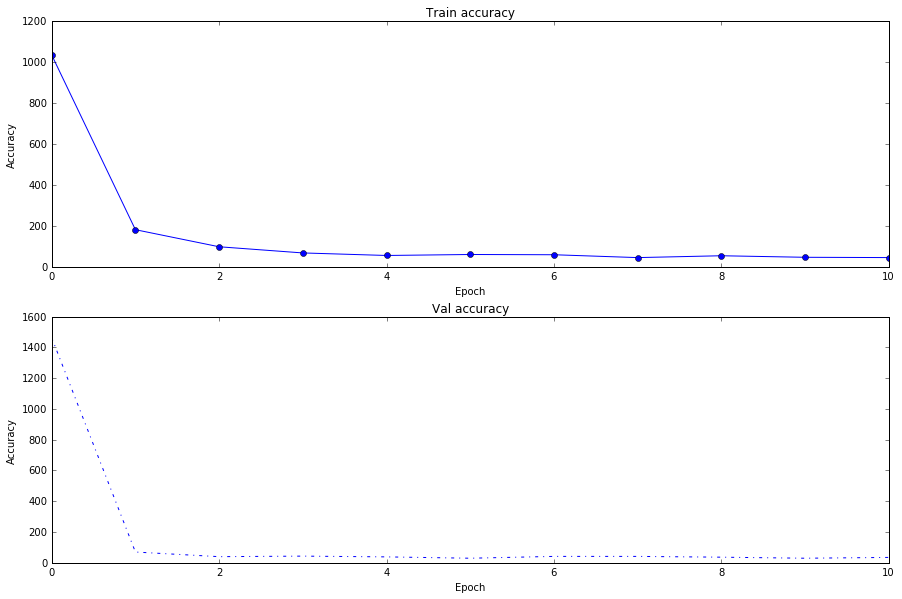

In [99]:
solvers = {}

best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
learning_rate = 1e-4
update_rule='adam'
model = AutoencoderNet([1000,1000], weight_scale=1e-2)

solver = Solver(model, small_data,
              num_epochs=10, batch_size=20,
              update_rule='adam',
              optim_config={
                'learning_rate': learning_rate
              },
              verbose=True,
              print_every=100)
solvers[update_rule] = solver
solver.train()
best_model = model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
# Plot train and validation accuracies of the model

plt.subplot(3, 1, 1)
plt.plot(solver.train_acc_history, '-o')
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.plot(solver.val_acc_history, '-.')
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')


plt.gcf().set_size_inches(15, 15)
plt.show()


(20L, 1000L)


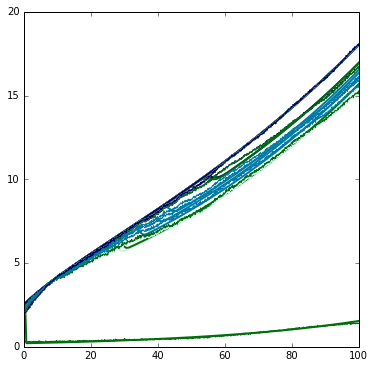

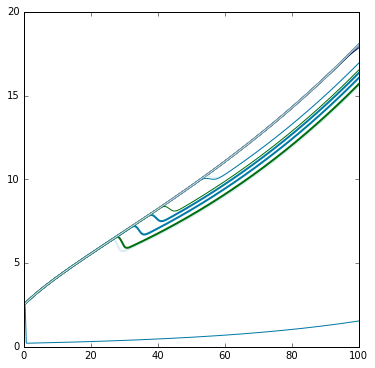

In [102]:
division = 1
#plot_it(solver.sample, 999, 1)
#plot_it(solver.sample_predictions, 999, 1)
def plot_it2(data, i=0, j=1, v_indices = np.array([0])):
    fig = plt.figure(figsize=(6,6))
    vspace = np.linspace(0.0, 100.0, 1000)[:, None]
    v = data[:data.shape[0]/2][::division].T
    w = data[data.shape[0]/2:][::division].T
    plt.gca().set_color_cycle(cm.ocean(np.linspace(0.95,0.05,4)))
    plt.plot(vspace, v, lw=2)
    plt.gca().set_prop_cycle(plt.matplotlib.rcParams['axes.prop_cycle'])
    plt.gca().set_color_cycle(cm.ocean(np.linspace(0.95,0.05,4)))
    plt.plot(vspace, w, lw=1)
    
    #plt.imshow()
test = solver.sample
test2 = np.concatenate((test,solver.sample_predictions), axis = 0)
print test.shape
plot_it2(test2, 999, 1)
plot_it2(test, 999, 1)

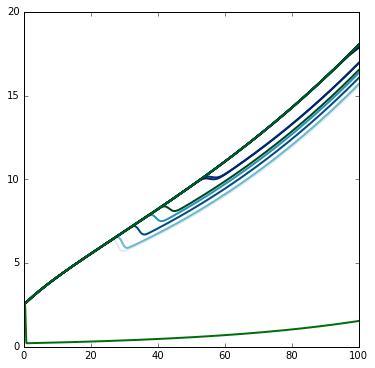

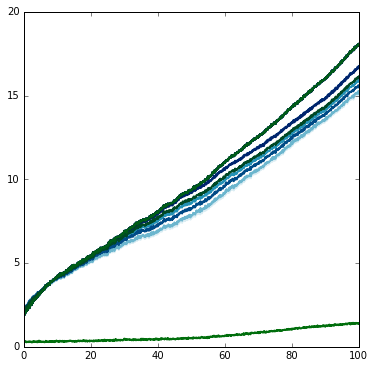

(40L, 1000L)

In [105]:
plot_it(solver.sample, 999, 1)
plot_it(solver.sample_predictions, 999, 1)
test = solver.sample
test = np.concatenate((test,solver.sample_predictions), axis = 0)
test.shape